In [33]:
# ДЗ
# 1. Подберите парамтеры алгоритма разрастания регионов так, чтобы был выделен весь участок газона.
# 2. Реализуйте вычисление критерия однородности, отличного от представленного. Сравните результаты.
# 3. Применить алгоритм сегментации watershed+distance transform для задачи подсчета пальмовых деревьев.

## 1. Импорты

In [39]:
import numpy as np
import cv2
from scipy import ndimage
import matplotlib.pyplot as plt

## 2. Загрузка изображения

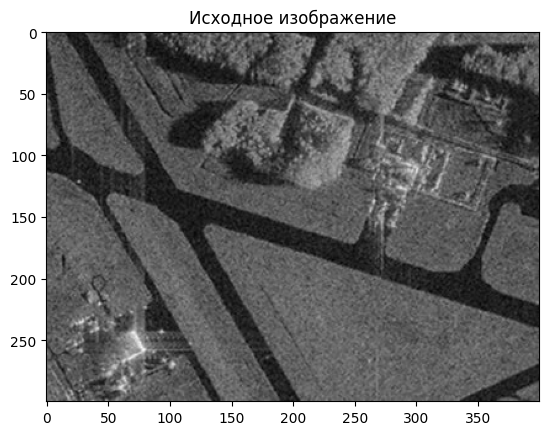

In [40]:
image = cv2.imread('sar_1.jpg')
image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
plt.imshow(image_gray, cmap="gray")
plt.title("Исходное изображение")
plt.show()

## 3. Выделение всего участка газона

In [41]:
import math
def homo_average(img, mask, point, T):
    av_val = img[mask > 0].sum() / np.count_nonzero(img[mask > 0])

    if abs(av_val - img[point]) <= T:
        return True

    return False

In [42]:
def region_growing(image, seed_point,homo_fun,r, T):
    mask = np.zeros(image_gray.shape, np.uint8)
    mask[seed_point] = 1
    count = 1
    while count > 0:
        count = 0
        local_mask = np.zeros(image_gray.shape, np.uint8)
        for i in range(r,image.shape[0] - r):
            for j in range(r,image.shape[1] - r):
                if mask[i,j]==0 and mask[i - r:i + r, j-r: j+r].sum() > 0:
                    if homo_fun(image, mask, (i,j), T):
                        local_mask[i,j] = 1
        count = np.count_nonzero(local_mask)
        mask += local_mask

    return mask*255

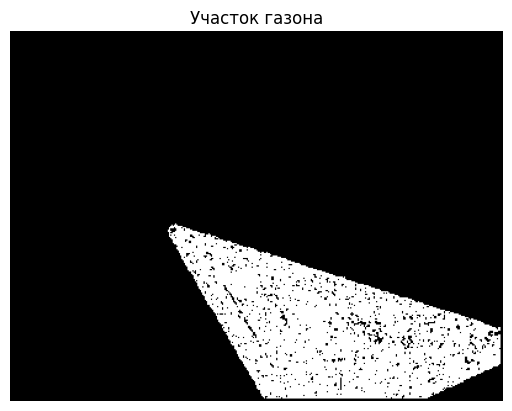

In [43]:
seed_point = (250, 250)
mask_lawn_avg = region_growing(image_gray, seed_point, homo_average, 2, 15)

plt.imshow(mask_lawn_avg, cmap="gray")
plt.title("Участок газона")
plt.axis("off")
plt.show()


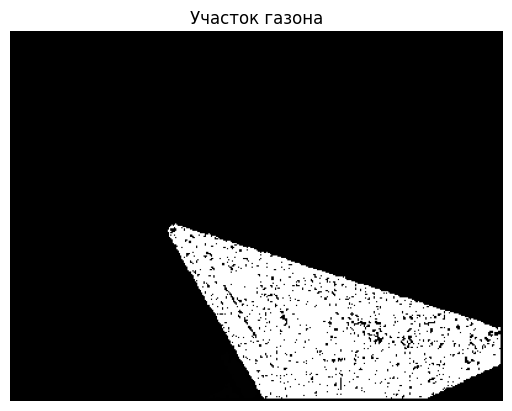

In [44]:
seed_point = (250, 250)
r = 2
T = 15

mask = region_growing(image_gray, seed_point, homo_average, r, T).astype(np.uint8)

def homo_fun(image, mask, i, j, r, T):
    # окно r вокруг (i, j)
    win_img = image[i-r:i+r+1, j-r:j+r+1]
    win_msk = mask[i-r:i+r+1, j-r:j+r+1]
    neigh = win_img[win_msk > 0]
    if neigh.size == 0:
        return False
    return abs(float(image[i, j]) - float(neigh.mean())) <= T

local_mask = mask.copy()
H, W = image_gray.shape

for i in range(r, H - r):
    for j in range(r, W - r):
        if local_mask[i, j] == 0 and local_mask[i-r:i+r+1, j-r:j+r+1].sum() > 0:
            if homo_fun(image_gray, local_mask, i, j, r, T):
                local_mask[i, j] = 1

plt.imshow(local_mask, cmap="gray")
plt.title("Участок газона")
plt.axis("off")
plt.show()


## 4. Вычисляем критерии однородности

Text(0.5, 1.0, 'K = 10')

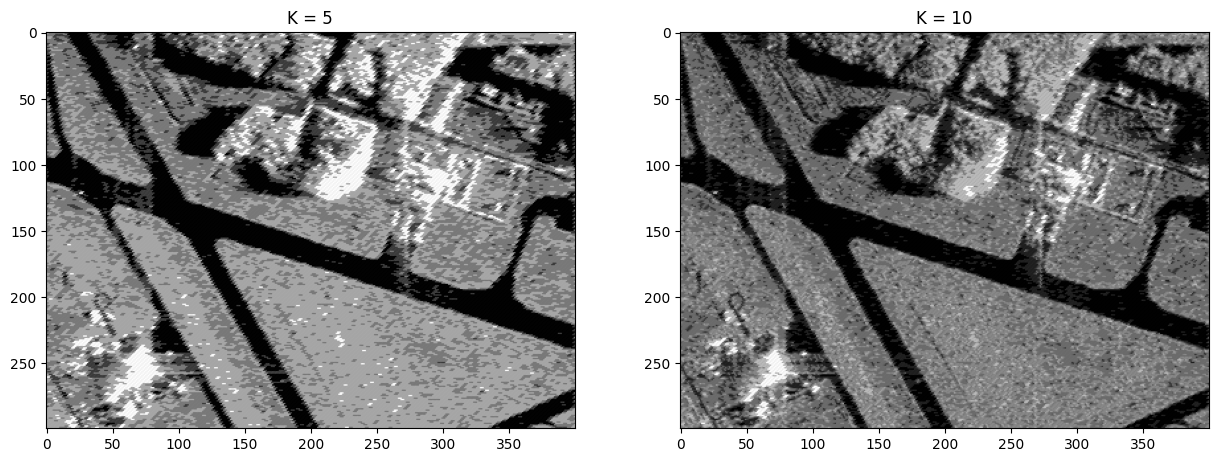

In [45]:
image = cv2.imread('sar_1.jpg')
image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

flags = cv2.KMEANS_RANDOM_CENTERS
z = image_gray.reshape((-1,3))
z = np.float32(z)
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
K = 5
ret,label,center=cv2.kmeans(z,K,None,criteria,10,cv2.KMEANS_RANDOM_CENTERS)
center = np.uint8(center)
res = center[label.flatten()]
res2 = res.reshape((image_gray.shape))

plt.figure(figsize=(15, 12))
plt.subplot(1, 2, 1)
plt.imshow(res2, cmap="gray")
plt.title("K = 5")

K = 10
ret,label,center=cv2.kmeans(z,K,None,criteria,10,cv2.KMEANS_RANDOM_CENTERS)
center = np.uint8(center)
res = center[label.flatten()]
res2 = res.reshape((image_gray.shape))

plt.subplot(1, 2, 2)
plt.imshow(res2, cmap="gray")
plt.title("K = 10")

## 5.Алгоритм сегментации watershed+distance transform

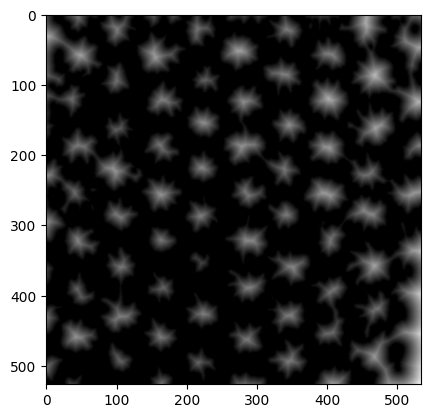

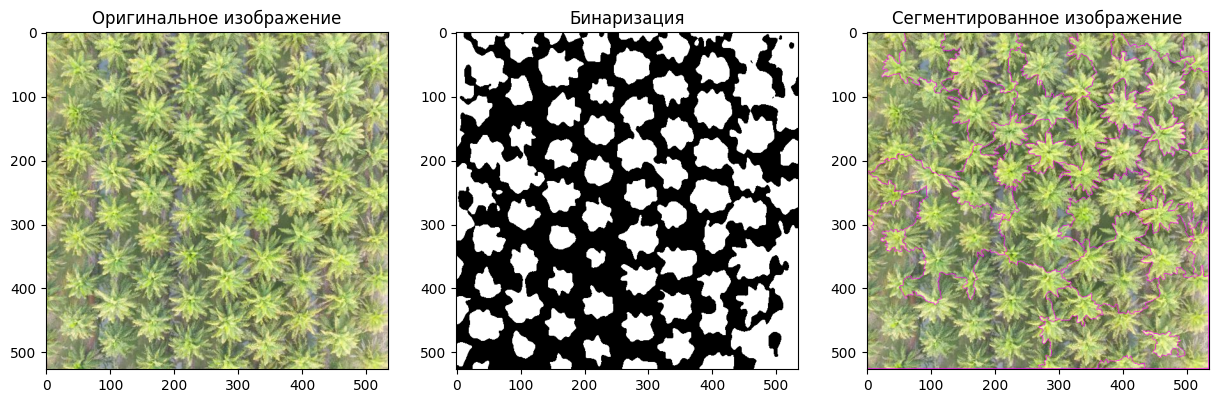

Найдено пальм: 35


In [46]:
image = cv2.imread("palm_1.jpg")
image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

blurred = cv2.GaussianBlur(image_gray, (21, 29), 0)
ret, thresh = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
dist_transform = cv2.distanceTransform(thresh, cv2.DIST_L2, 5)

plt.imshow(dist_transform, cmap="gray")

local_maxima = ndimage.maximum_filter(dist_transform, size=20, mode='constant')

ret, sure_fg = cv2.threshold(dist_transform, 0.5 * dist_transform.max(), 255, cv2.THRESH_BINARY)
sure_fg = sure_fg.astype(np.uint8)
ret, markers = cv2.connectedComponents(sure_fg)
markers = cv2.watershed(image, markers.astype(np.int32))

num = len(np.unique(markers)) - 1

segmented_image = image.copy()
segmented_image[markers == -1] = [255, 0, 255]

plt.figure(figsize=(15, 12))
plt.subplot(1, 3, 1)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title("Оригинальное изображение")
plt.subplot(1, 3, 2)
plt.imshow(thresh, cmap="gray")
plt.title("Бинаризация")
plt.subplot(1, 3, 3)
plt.imshow(cv2.cvtColor(segmented_image, cv2.COLOR_BGR2RGB))
plt.title("Сегментированное изображение")
plt.show()
print("Найдено пальм:", num)